In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42


config = Config()
sys.path.append(str(config.REPO_ROOT))

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

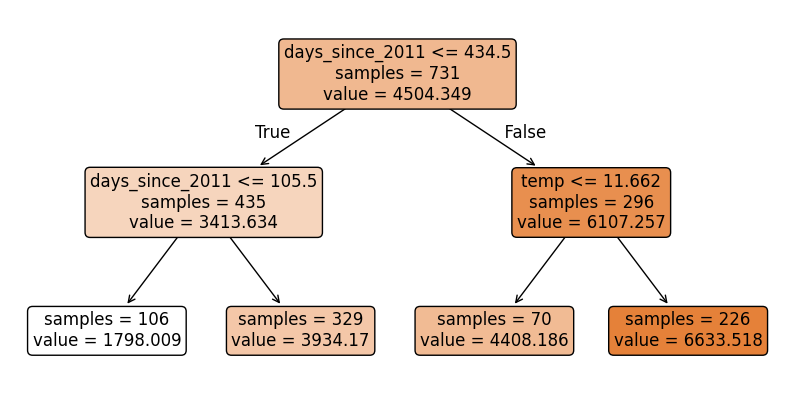

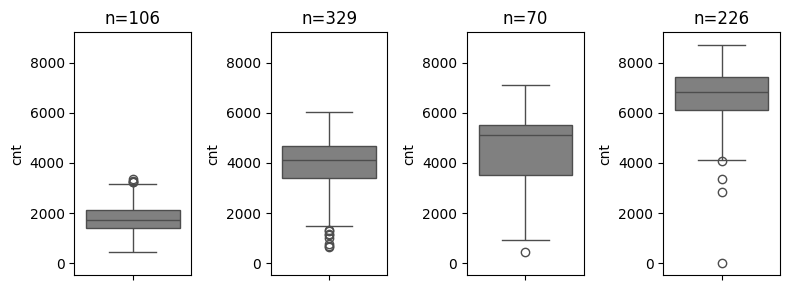

In [3]:
features_of_interest = [
    "days_since_2011",
    "temp",
    "season",
    "windspeed",
    "hum",
]
df_bike_processed["season"] = df_bike_processed["season"].map(
    {"WINTER": 1, "SPRING": 2, "SUMMER": 3, "FALL": 4}
)
X = df_bike_processed[features_of_interest]
y = df_bike_processed["cnt"]
tree_model = DecisionTreeRegressor(max_depth=2, random_state=config.seed)
tree_model.fit(X, y)

plt.figure(figsize=(10, 5))
plot_tree(
    tree_model,
    feature_names=features_of_interest,
    filled=True,
    rounded=True,
    fontsize=12,
    impurity=False,
)
plt.show()


def get_node_data(tree, X, node_id):
    node_indicator = tree.decision_path(X)
    return X[node_indicator[:, node_id].toarray().flatten() == 1]


terminal_nodes = tree_model.apply(X)

fig, axes = plt.subplots(1, 4, figsize=(8, 3))
y_min = y.min()
y_max = y.max()

for i, node_id in enumerate(np.unique(terminal_nodes)):
    node_data = get_node_data(tree_model, X, node_id)
    node_y = y.loc[node_data.index]
    sns.boxplot(y=node_y, ax=axes[i], color="gray")
    axes[i].set_title(f"n={len(node_y)}")
    axes[i].set_ylim(y_min - 500, y_max + 500)

plt.tight_layout()
plt.show()

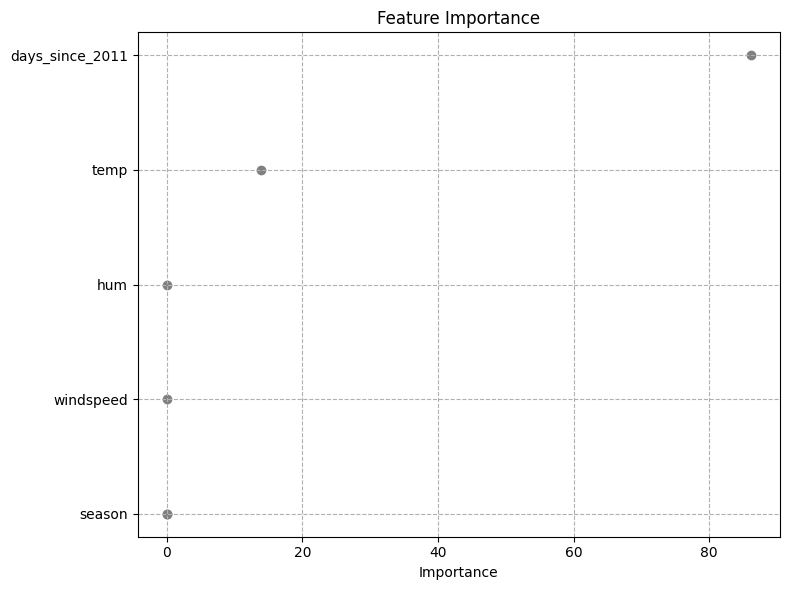

In [4]:
imp = 100 * tree_model.feature_importances_ / np.sum(tree_model.feature_importances_)
imp_df = pd.DataFrame({"feature": X.columns, "importance": imp})
season_importance = imp_df[imp_df["feature"].str.startswith("season_")][
    "importance"
].sum()

imp_df = imp_df[~imp_df["feature"].str.startswith("season_")]
imp_df = pd.concat(
    [imp_df, pd.DataFrame({"feature": ["season"], "importance": [season_importance]})],
    ignore_index=True,
)
imp_df = imp_df.sort_values("importance")

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(imp_df["importance"], imp_df["feature"], color="gray")
ax.set_ylabel("")
ax.set_xlabel("Importance")
ax.set_title("Feature Importance")
ax.grid(linestyle="--")
plt.tight_layout()
plt.show()